
|평가문항|상세기준|
|:--|:--|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|

In [37]:
import tensorflow as tf
import numpy as np
import cv2
import PIL
import copy

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os

## 실습 재료 준비하기 
### 첫번째, tfds로부터 데이터셋 불러오기

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    data_dir='~/aiffel/CV-ClassActivationMap/tensorflow_datasets',
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/aiffel/CV-ClassActivationMap/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


### 어떤 자료가 도착했는지 쓱~ 톭아볼까요

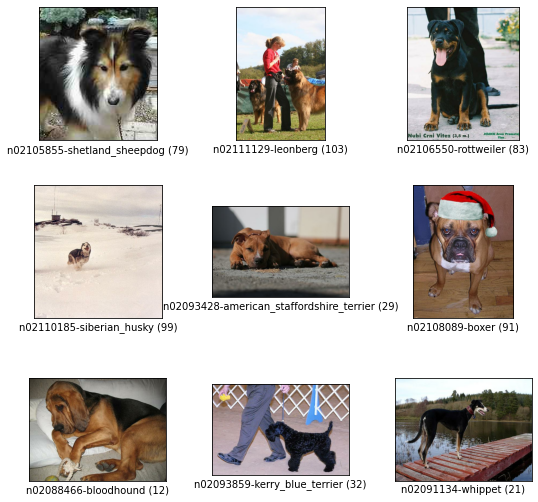

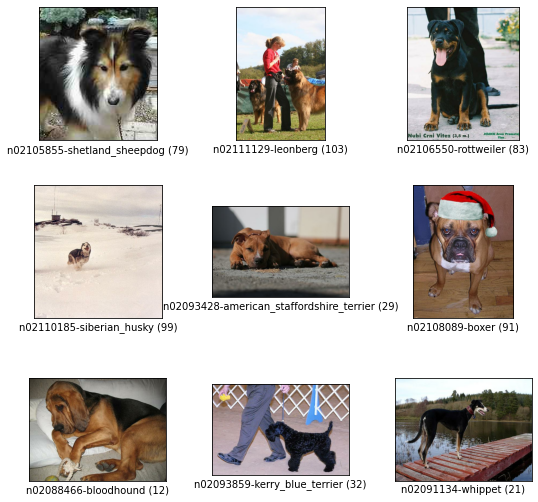

In [8]:
tfds.show_examples(ds_train, ds_info)

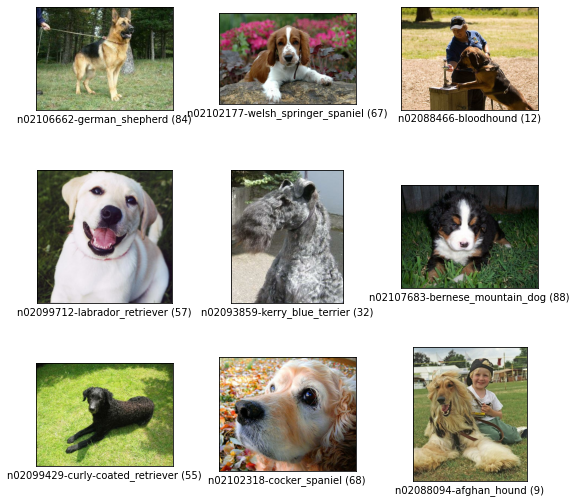

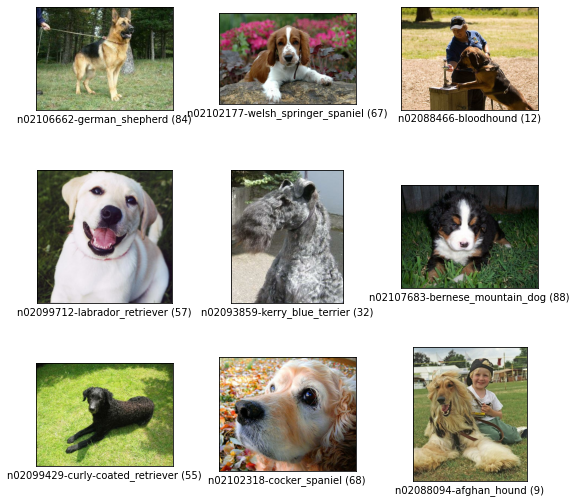

In [7]:
tfds.show_examples(ds_test, ds_info)

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

#### 귀여운 댕댕쓰들이 잔뜩 놀러왔네요!

- 이미지의 Shape이 `(None, None, 3)`인 이유는 이미지의 __가로(Width), 세로(Height)__ 가 하나로 통일되어 있지 않아서 `None`으로 표기되며 마지막 3은 모든 이미지가 RGB 컬러 이미지라서 그렇습니다.
- 이미지 파일명은 Text로 이루어져 있으며 __label은 총 120가지__ 로 나뉘어 있습니다.
- BoundingBox 어노테이션이 실시되어 있음을 알 수 있습니다.  

`BBoxFeature`의 어노테이션 정보는 `(ymin, xmin, ymax, xmax)`로 구성되어 있습니다.  
![Tensorflow 공식 정보](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)

### 두번째, 불러운 재료 각 맞춰 정돈하기!

In [19]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [21]:
# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


이렇게 데이터셋은 모두 준비가 완료 되었습니다.

이제 분류 모델과 오늘의 하이라트 __CAM, Grad-CAM__ 모델을 준비해보겠습니다.

## ResNet-50 모델 수정하기

- Tensorflow에서 제공하는 ResNet-50 API에서 Feature 추출이후 FC 레이어로 넘어가기 전 활성화된 이미지를 보기 위해 약간 수정이 필요하다.

In [22]:
num_classes = ds_info.features['label'].num_classes

base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
preds = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = tf.keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [23]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [27]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [31]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=5,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)
cam_model.save('./cam_model.h5')

Epoch 1/5
750/750 [==============================] - 164s 214ms/step - loss: 1.4666 - accuracy: 0.6137 - val_loss: 1.7766 - val_accuracy: 0.5102
Epoch 2/5
750/750 [==============================] - 155s 207ms/step - loss: 0.5226 - accuracy: 0.8654 - val_loss: 1.1766 - val_accuracy: 0.6524
Epoch 3/5
750/750 [==============================] - 155s 207ms/step - loss: 0.1496 - accuracy: 0.9753 - val_loss: 0.9411 - val_accuracy: 0.7231
Epoch 4/5
750/750 [==============================] - 155s 207ms/step - loss: 0.0485 - accuracy: 0.9963 - val_loss: 0.9258 - val_accuracy: 0.7344
Epoch 5/5
750/750 [==============================] - 155s 207ms/step - loss: 0.0239 - accuracy: 0.9990 - val_loss: 0.9367 - val_accuracy: 0.7320


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## CAM 실습하기
### CAM 모델에 넣을 이미지를 준비합니다.

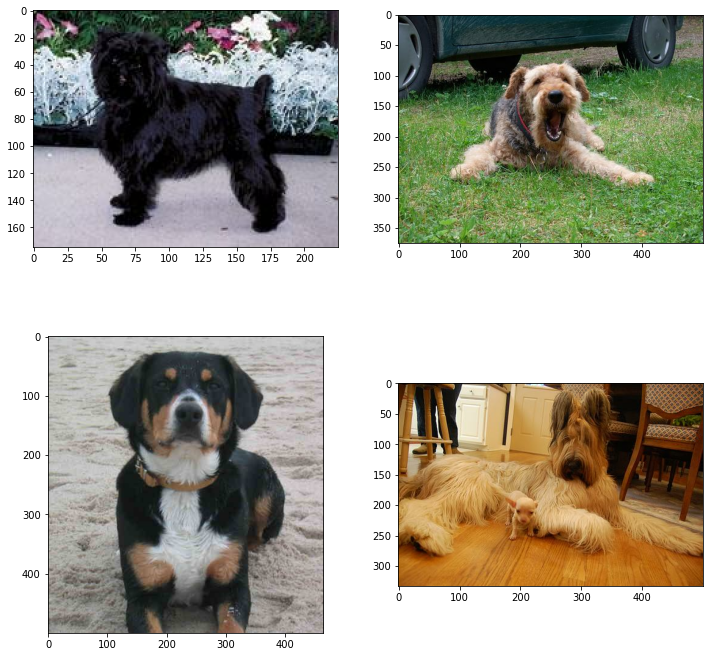

In [307]:
ds = ds_test.take(4)
items = []
for i in list(ds.as_numpy_iterator()):
    items.append(i)

plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(items[i]['image'])

### Class Activation Map(CAM) 모델을 구현합니다.

In [252]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    # cam_model의 inputs shape이 4D 랭크 텐서로 구성되어 있어, 차원을 맞추기 위해 tf.expand_dims() 함수를 사용합니다.
    # img_tesnsor.shape : (224, 224, 3) -> (1, 224, 224, 3)
    # cam_moodel에 img_tensor를 넣어 conv_outputs와 predictions을 구합니다.
    # predictions는 최종 softmax함수까지 통과한 output이 저장됩니다.
    # predictions.shape : (1, 120)
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) 
    # conv_outputs.shape : (1, 7, 7, 2048)인데, (H, W ,C)로 변환합니다. (7, 7, 2048)
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    # GAP을 통해 생성된 (None, 2048)가 -- Dense Layer--> (120, )벡터로 변환되고
    # (120, )이 --softmax--> (120, )이며 값들은 각 Class의 확률 정보가 저장 됩니다.
    # 이에 get_weights는 (Dense Layer 변환 weights(2048, 120), bias(120,))가 저장됩니다.)
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    # class_weights[:, class_idx].shape : (2048, )와 conv_outputs.shape : [7, 7, 2048]
    # A사진으로부터 Class를 추출하는 (2048, 120) 가중치로부터 class_idx에 해당하는 (2048, ) 벡터의 각 elements를 
    # 마지막 convoulution의 결과(7, 7, 2048)의 0번째 채널에 곱한다.
    # cam_image는 
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        # print(f"w.shape: {w}, con_outputs[:, :, i].shape: {conv_outputs[:, :, i].shape}")
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

![](https://velog.velcdn.com/images/joonlaxy/post/c3dccfba-af37-43b1-b378-eb2a48229a60/image.jpg)

__cam_image__는 `Layer[-3].output`과 `Layers[-1].get_weights[0]`에서 softmax결과 class`(그림에서는 class 28)`에 해당하는 `weights`(`shape은 (2048, )`)을 통해 계산된다.

In [217]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

원본 이미지와 CAM 이미지의 투명도를 조정하여 겹쳐 보여주는 기능 수행

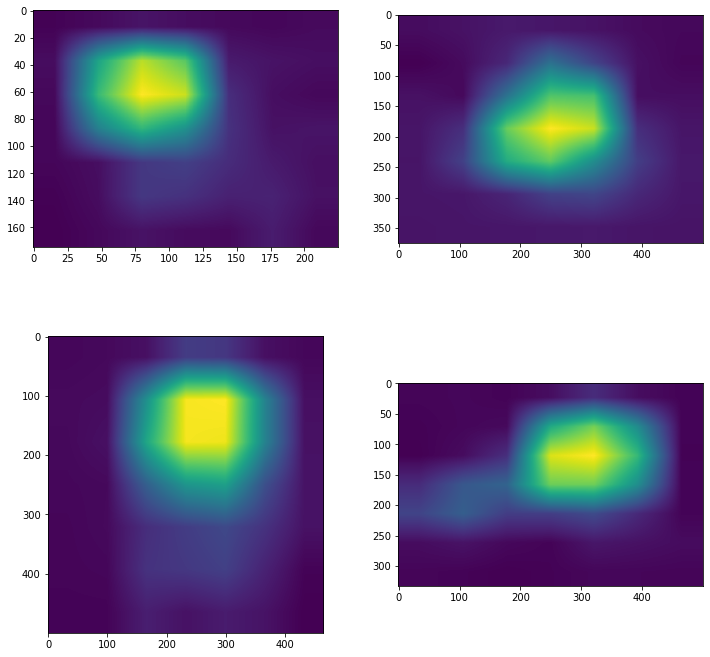

In [308]:
plt.figure(figsize=(12, 12))
cam_images = []
for i, v in enumerate(items):
    cam_images.append(generate_cam(cam_model, v))
    
    plt.subplot(2, 2, i+1)
    plt.imshow(cam_images[i])

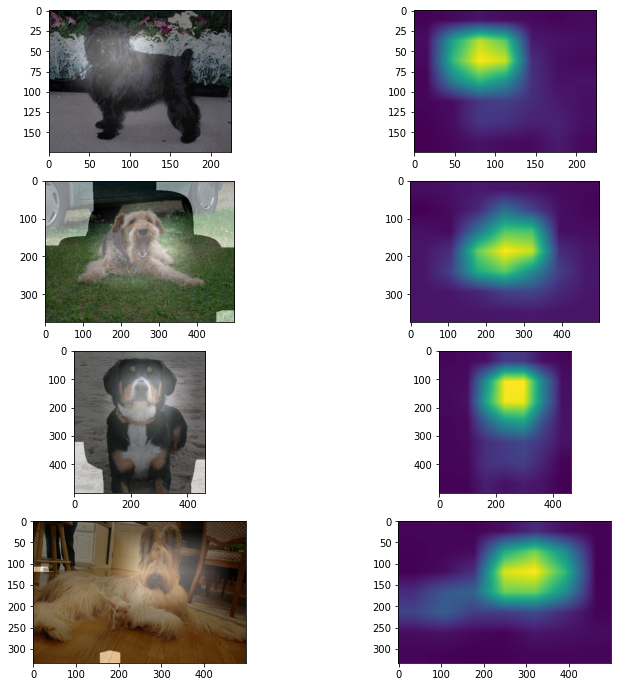

In [309]:
plt.figure(figsize=(12, 12))
blended_images = []
for i in range(4):
    blended_images.append(visualize_cam_on_image(np.stack([cam_images[i]*255]*3, axis=-1).astype(np.uint8), 
                                                 items[i]['image'].astype(np.uint8)))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(blended_images[i])
    plt.subplot(4, 2, 2*i+2)    
    plt.imshow(cam_images[i])

## Grad-CAM 구현하기

Grad-CAM은 CAM과 달리 Weights를 가져오지 않고, Gradient를 계산해야합니다.  
따라서 `with tf.GradientTape() as tape:`을 통해 Gradient 계산을 실시합니다.


In [147]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

### Conv2_block에서의 Grad-CAM

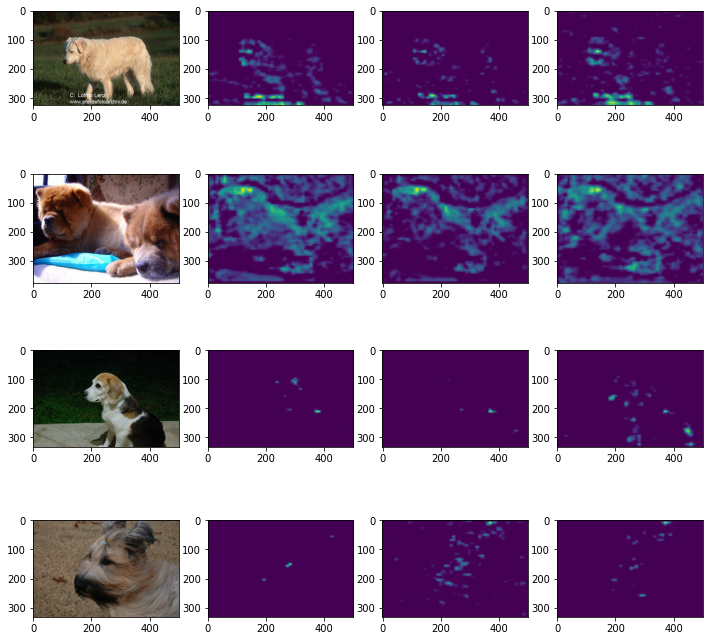

In [289]:
grad_cam_conv2_images = []
for i in items:
    grad_cam_conv2_images.append(i['image'])
    for v in range(3):
        grad_cam_conv2_images.append(generate_grad_cam(cam_model, f'conv2_block{v+1}_out', i))

plt.figure(figsize=(12,12))
for k, v in enumerate(grad_cam_conv2_images):
    plt.subplot(4, 4, k+1)
    plt.imshow(v)

### Conv3_block에서의 Grad-CAM

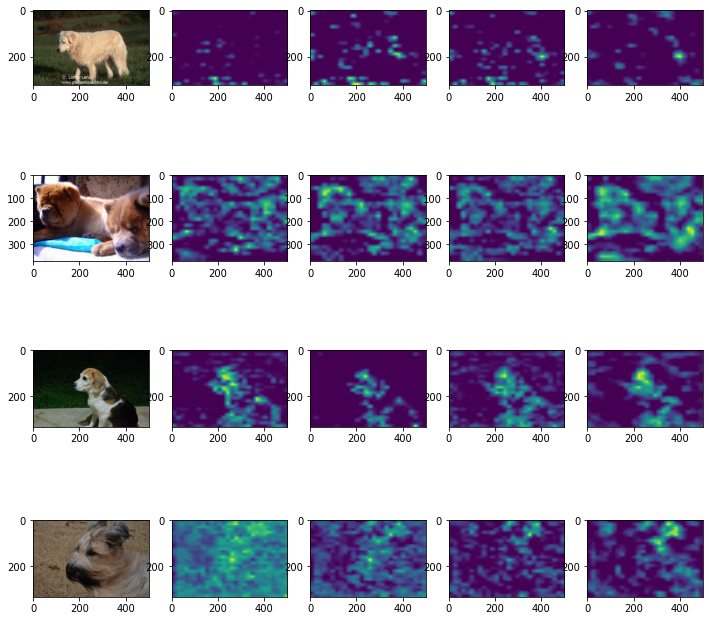

In [290]:
grad_cam_conv3_images = []
for i in items:
    grad_cam_conv3_images.append(i['image'])
    for v in range(4):
        grad_cam_conv3_images.append(generate_grad_cam(cam_model, f'conv3_block{v+1}_out', i))

plt.figure(figsize=(12,12))
for k, v in enumerate(grad_cam_conv3_images):
    plt.subplot(4, 5, k+1)
    plt.imshow(v)

### Conv4_block에서의 Grad-CAM

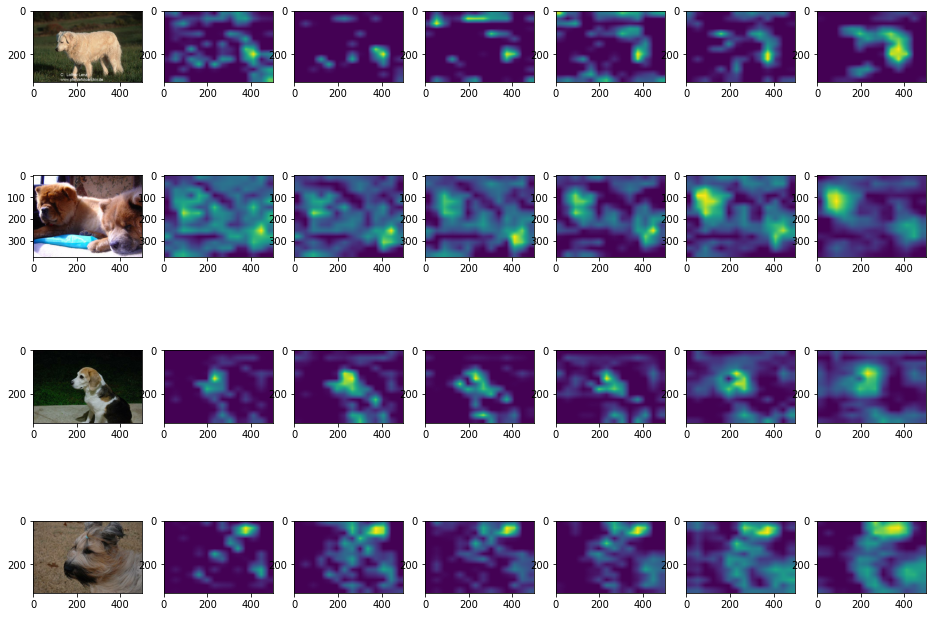

In [288]:
grad_cam_conv4_images = []
for i in items:
    grad_cam_conv4_images.append(i['image'])
    for v in range(6):
        grad_cam_conv4_images.append(generate_grad_cam(cam_model, f'conv4_block{v+1}_out', i))

plt.figure(figsize=(16,12))
for k, v in enumerate(grad_cam_conv4_images):
    plt.subplot(4, 7, k+1)
    plt.imshow(v)

### Conv5_block에서의 Grad-CAM

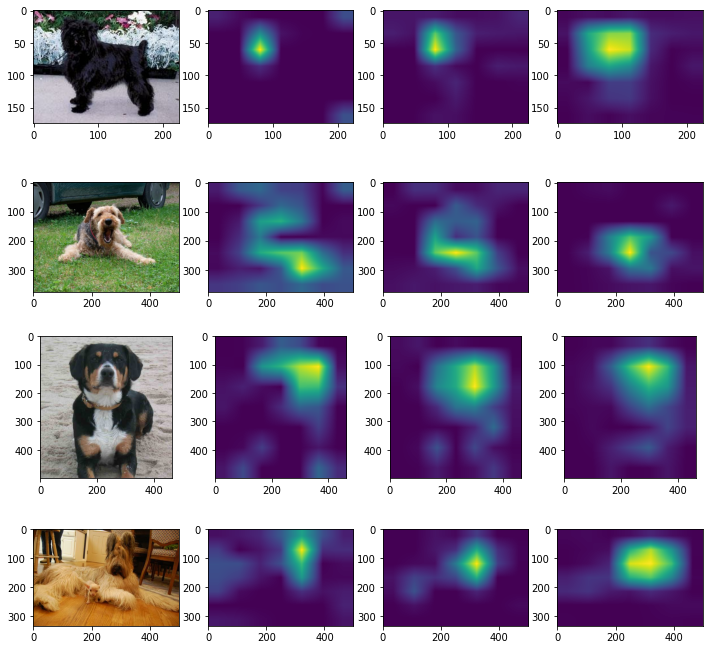

In [313]:
grad_cam_conv5_images = []
for i in items:
    grad_cam_conv5_images.append(i['image'])
    for v in range(3):
        grad_cam_conv5_images.append(generate_grad_cam(cam_model, f'conv5_block{v+1}_out', i))

plt.figure(figsize=(12,12))
for k, v in enumerate(grad_cam_conv5_images):
    plt.subplot(4, 4, k+1)
    plt.imshow(v)

맨 오른쪽 열의 이미지는 최종으로 검출되는 Grad-CAM 이미지입니다.

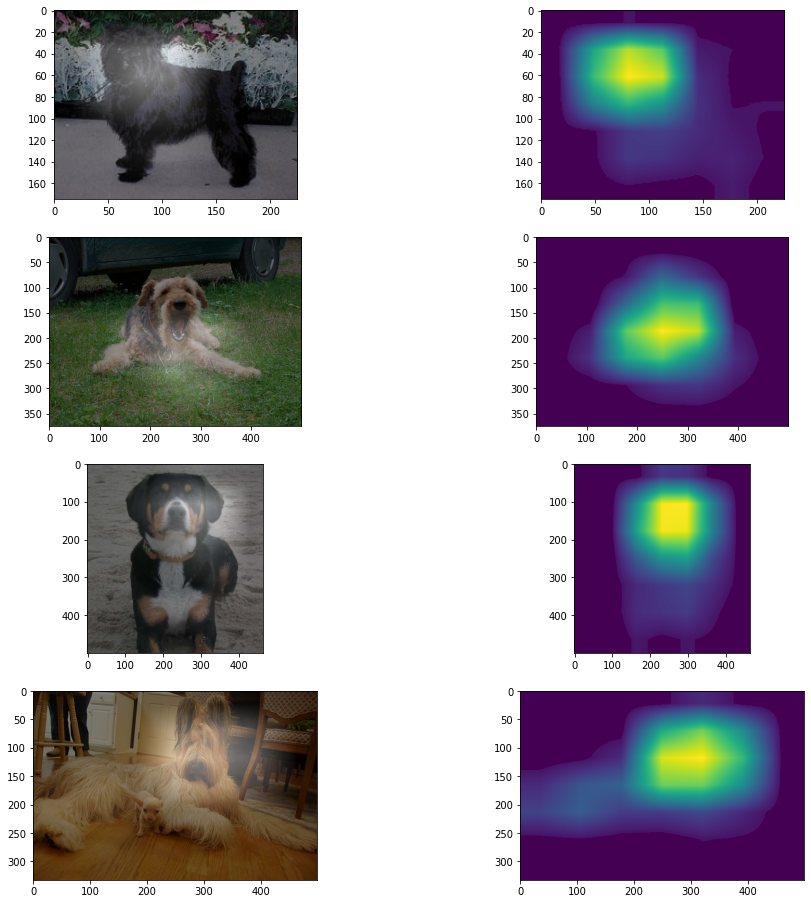

In [314]:
plt.figure(figsize=(16, 16))
blended_images = []
for i in range(4):
    blended_images.append(visualize_cam_on_image(np.stack([grad_cam_conv5_images[4*i+3]*255]*3, axis=-1).astype(np.uint8), 
                                                 items[i]['image'].astype(np.uint8)))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(blended_images[i])
    plt.subplot(4, 2, 2*i+2)    
    plt.imshow(cam_images[i])

최종 Grad-CAM 이미지와 원본 이미지를 합성을 통해 모델이 객체를 잘 주시하고 있음을 알 수 있습니다.

In [315]:
grad_cam_images = []
for i in range(4):
    grad_cam_images.append(grad_cam_conv5_images[4*i+3])

In [326]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [327]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [157]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

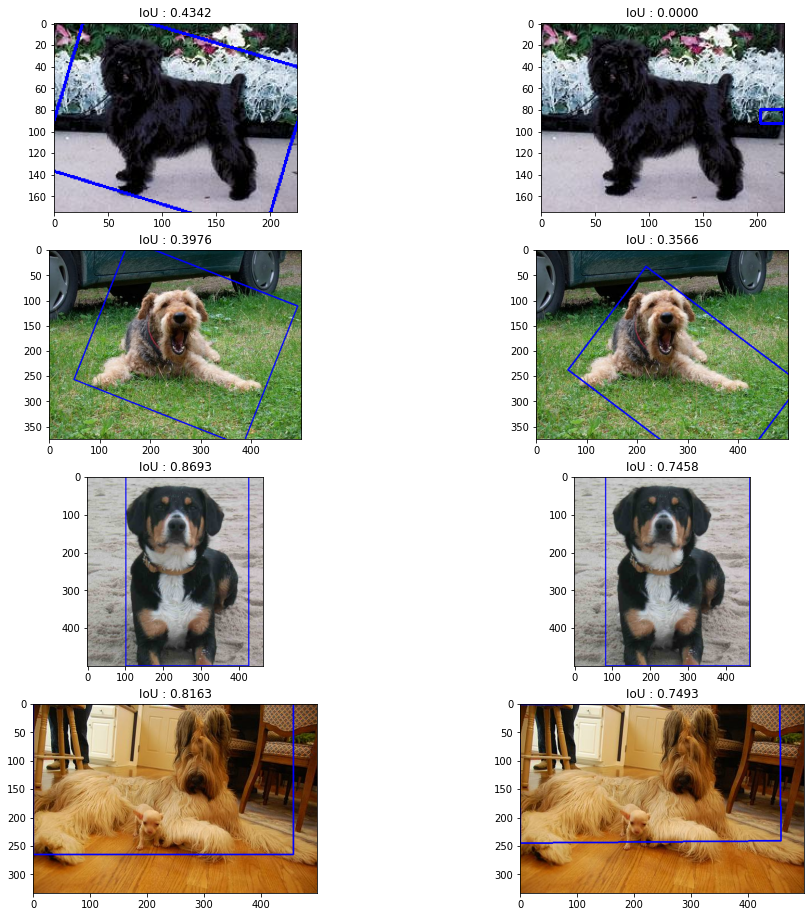

In [340]:
plt.figure(figsize=(16, 16))
cp_image_1 = []
cp_image_2 = []
for i in range(4):
    plt.subplot(4, 2, 2*i+1)
    plt.title(f"IoU : {get_iou(rect_to_minmax(get_bbox(cam_images[i]), items[i]['image']), items[i]['objects']['bbox'][0]):.4f}")
    cp_image_1.append(copy.deepcopy(items[i]['image']))
    plt.imshow(cv2.drawContours(cp_image_1[i], [get_bbox(cam_images[i])], 0, (0,0,255), 2))

for i in range(4):
    plt.subplot(4, 2, 2*i+2)
    plt.title(f"IoU : {get_iou(rect_to_minmax(get_bbox(grad_cam_images[i]), items[i]['image']), items[i]['objects']['bbox'][0]):.4f}")
    cp_image_2.append(copy.deepcopy(items[i]['image']))
    plt.imshow(cv2.drawContours(cp_image_2[i], [get_bbox(grad_cam_images[i])], 0, (0,0,255), 2))
    
plt.show()

### Bounding box 비교 결론
좌측열은 CAM을 통한 BBOX이고, 우측열은 Grad-CAM을 통한 BBOX입니다.  
전체적으로 Grad-CAM의 영역이 훨씬 더 크거나 잘못된 영역에 BBOX가 그려집니다.  
이는 `score_thresh`의 값을 통해 조절할 수 있지만, 동일한 비교를 위해 통일하여 진행하였습니다.

그 결과 IoU 값도 일반적인 CAM이 더 높은 점수를 얻을 수 있었습니다.